In [3]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


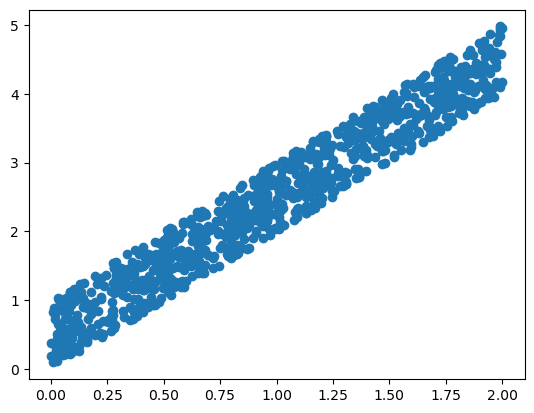

In [5]:
x1 = np.random.uniform(0, 2, 1000)
x2 = x1 * 2 + np.random.uniform(0, 1, 1000)


plt.scatter(x1, x2)

In [7]:
PCAmodel = PCA()
PCAmodel.fit(np.stack([x1, x2]).T)

PCA()

In [9]:
eigvecs = PCAmodel.components_
eigvals = PCAmodel.explained_variance_ratio_

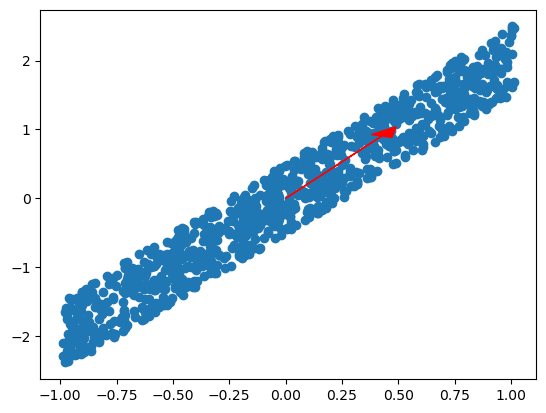

In [14]:
pcx1, pcy1 = eigvecs[0, :]

plt.scatter(x1-x1.mean(), x2-x2.mean())
plt.arrow(0, 0, pcx1, pcy1, color='red', head_width=0.1)

In [33]:

foo = np.ones((0, 5, 10))
foo.sum()


0.0

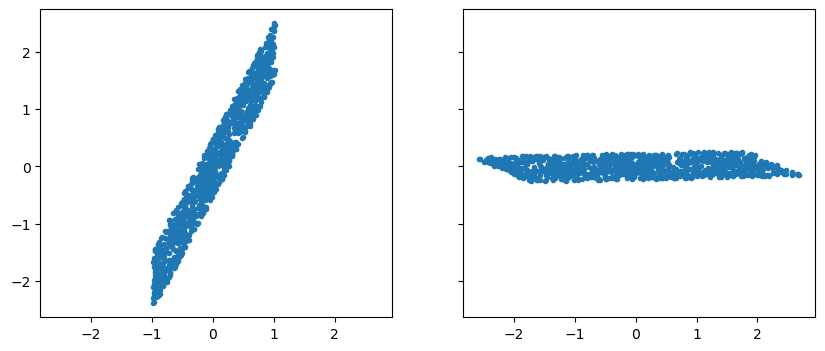

In [32]:

data = np.stack([x1, x2]).T

data2 = data - data.mean(axis=0, keepdims=True)


T = np.linalg.inv(eigvecs)
out = T @ data2.T
out = out.T

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
ax[0].scatter(data2[:, 0], data2[:, 1], marker='.')
ax[1].scatter(out[:, 0], out[:, 1], marker='.')

In [18]:
data.shape

(1000, 2)